In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import paths, utils
import nibabel as nib
from scipy.stats import pearsonr
from nilearn import plotting
import matplotlib.pyplot as plt

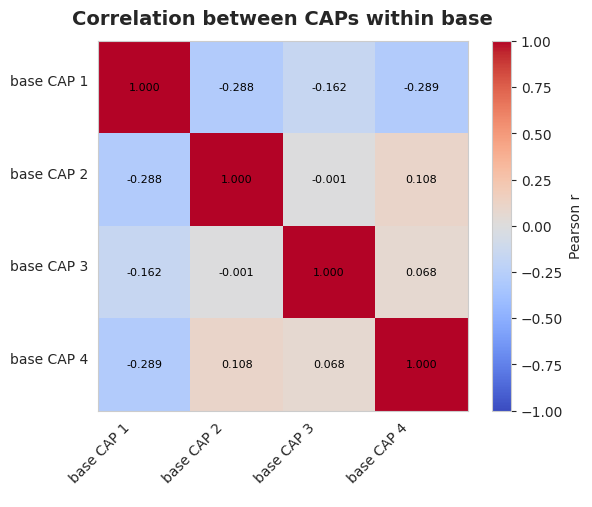

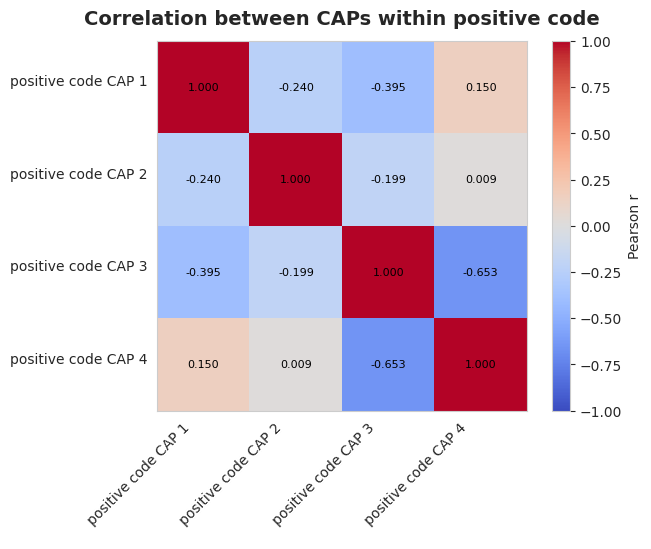

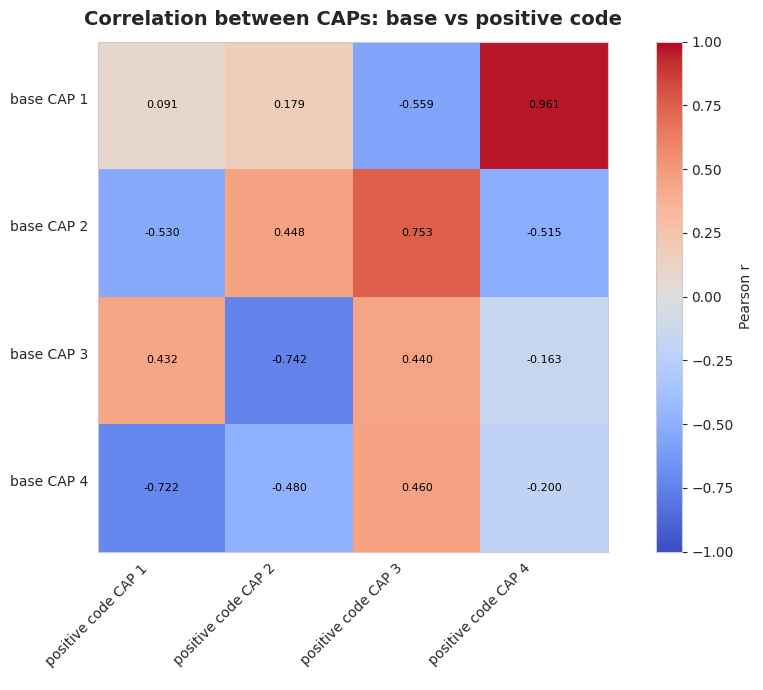

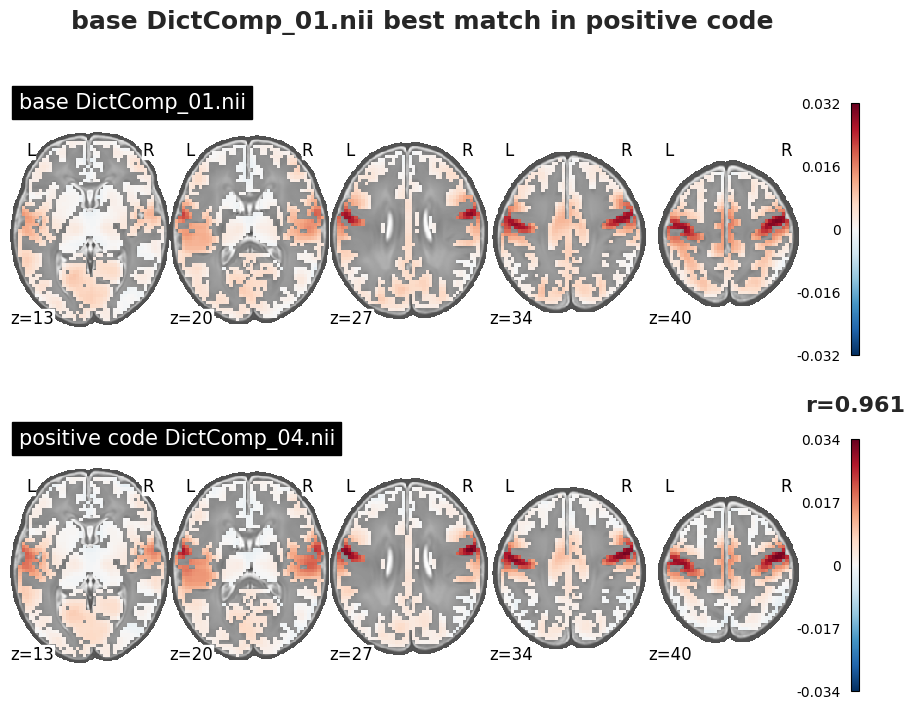

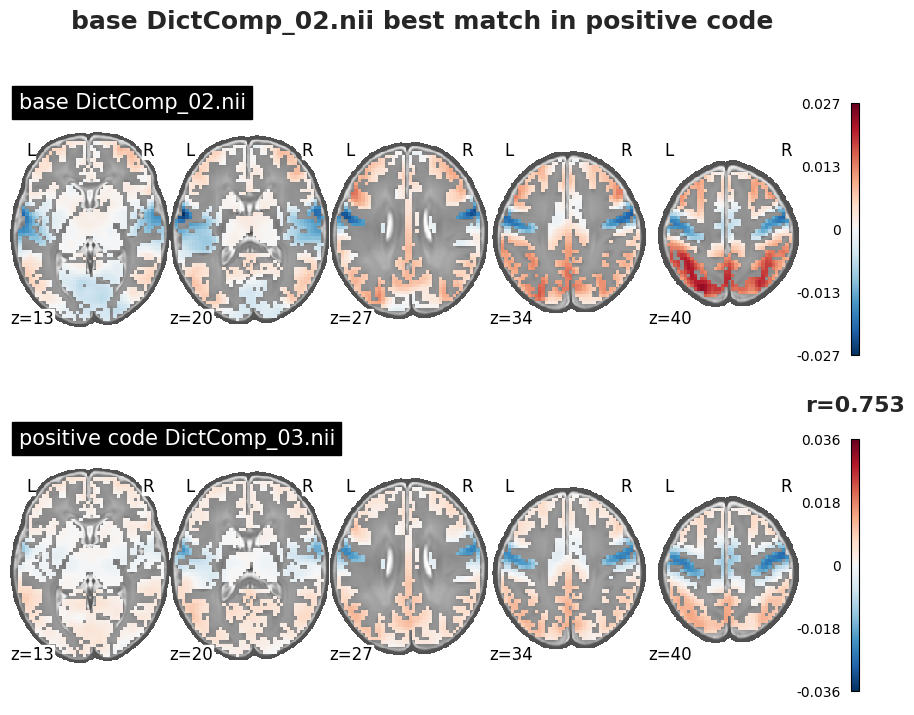

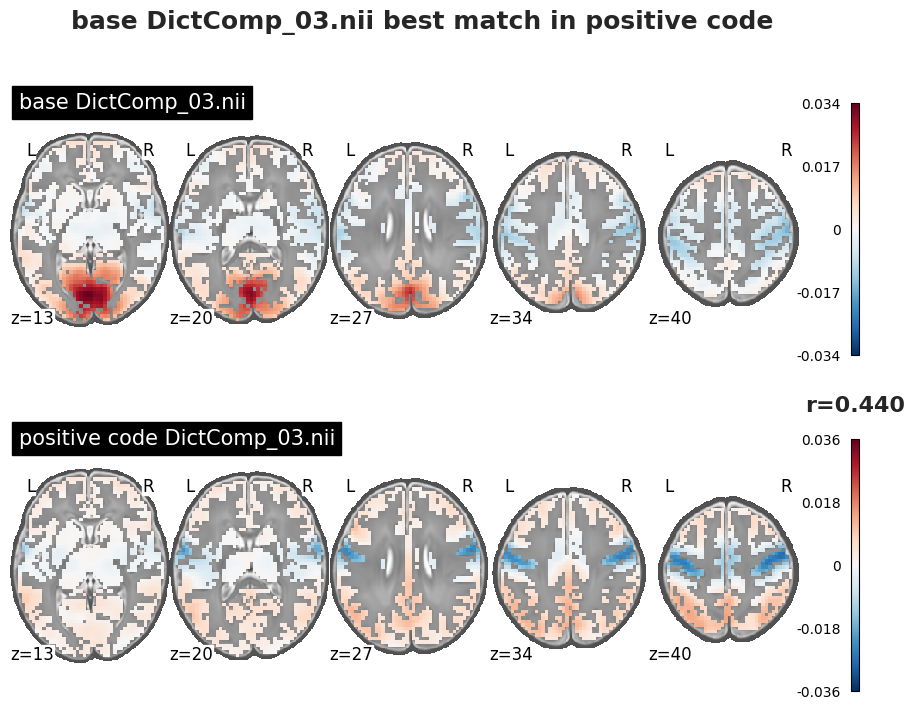

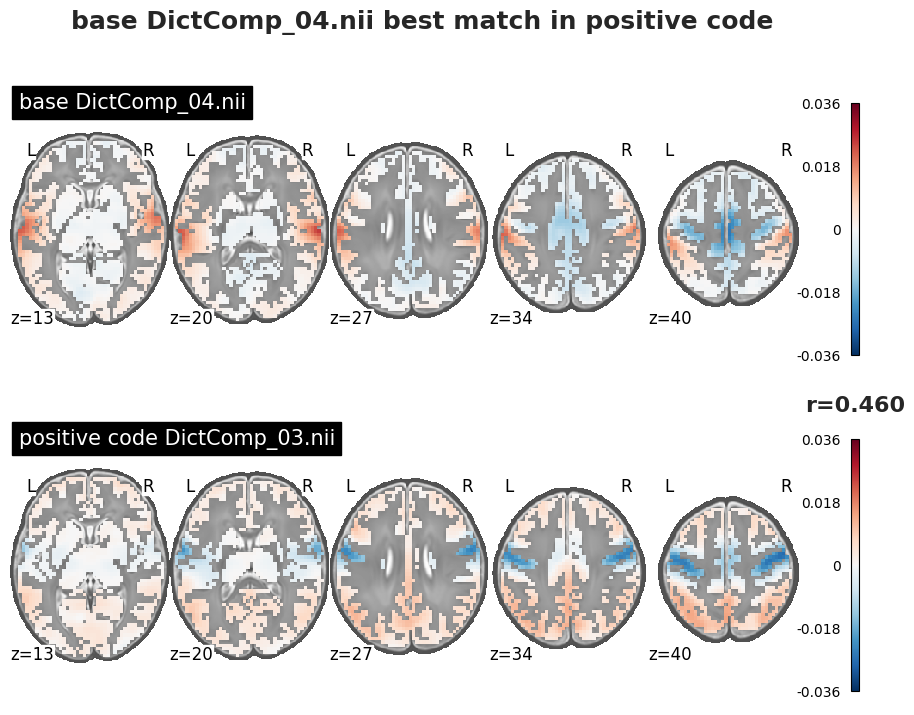

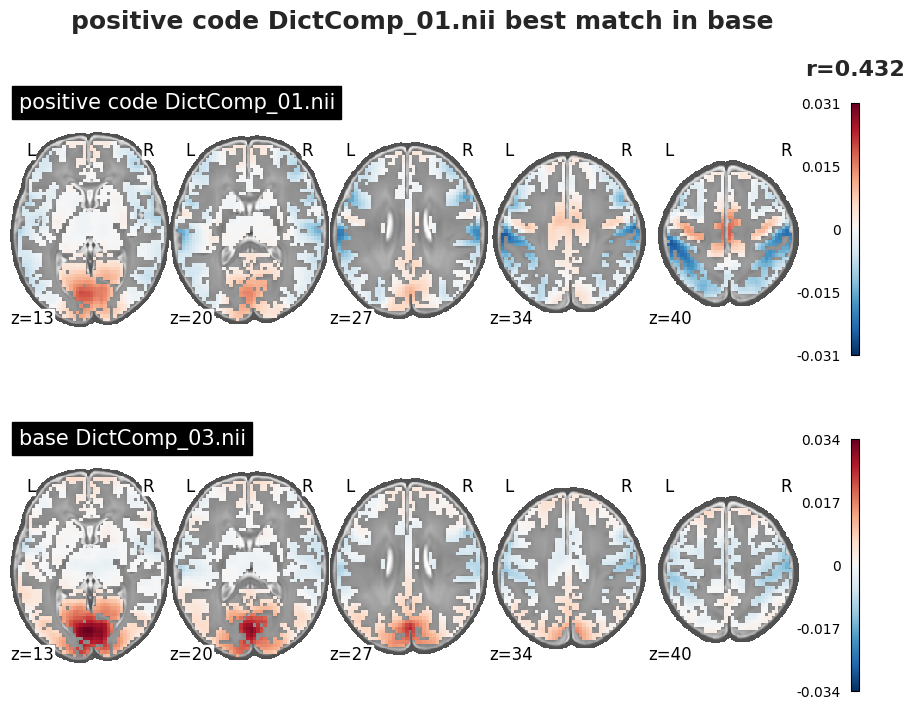

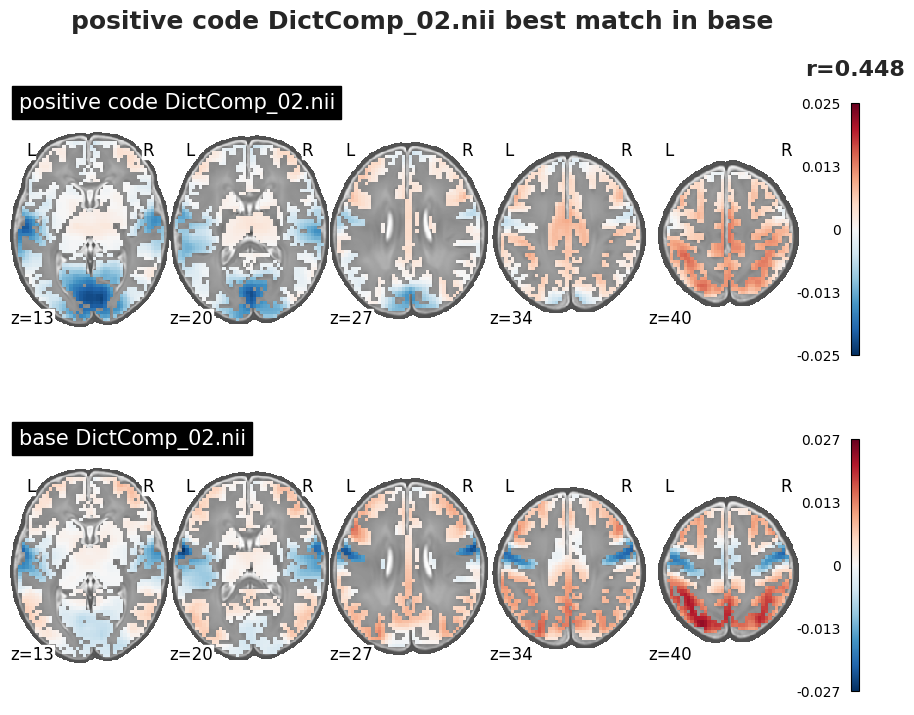

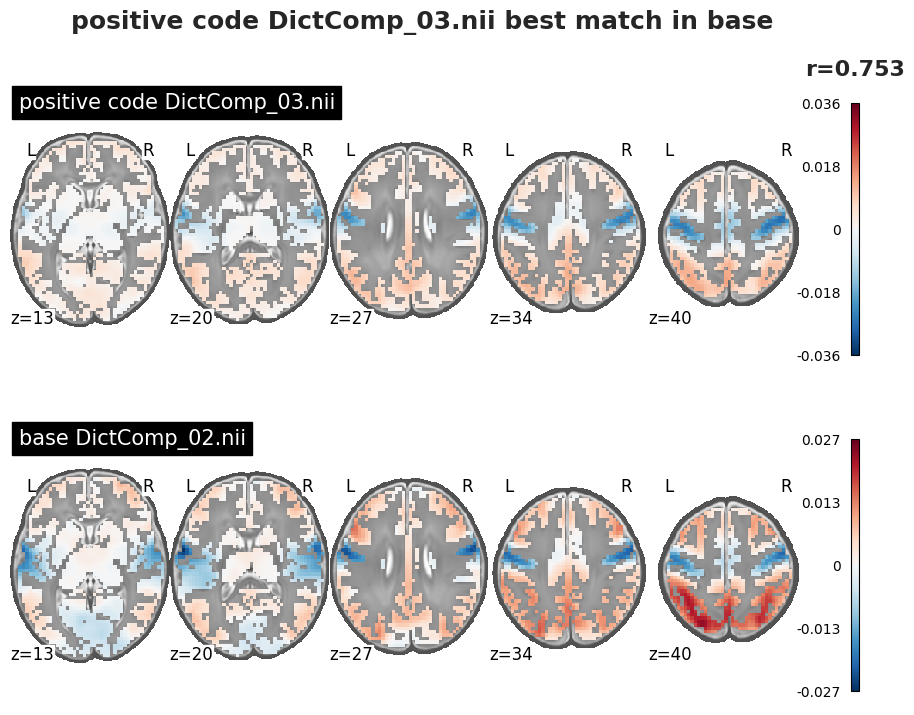

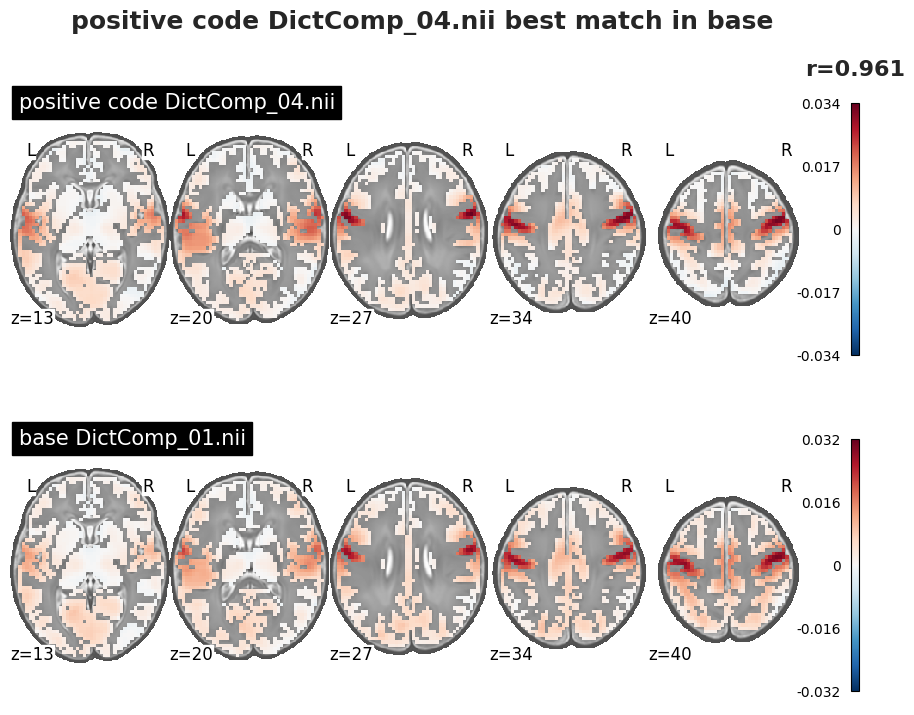

In [14]:
folderA = "DictLr_Ncomps-4_PosCode-False_Alpha-1.0_Tvalue-15_Act-pos_n-34"
folderA_name = "base"
folderA_glob = "DictComp_*.nii"

folderB = "DictLr_Ncomps-4_PosCode-True_Alpha-1.0_Tvalue-15_Act-pos_n-34"
folderB_name = "positive code"
folderB_glob = "DictComp_*.nii"

utils.compare_folder(
    folderA=folderA,
    folderB=folderB,
    folderA_name=folderA_name,
    folderB_name=folderB_name,
    folderA_glob=folderA_glob,
    folderB_glob=folderB_glob,
)